In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder   
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load all of the necessary dataset
try:
    results = pd.read_csv('results.csv')
    races = pd.read_csv('races.csv')
    drivers = pd.read_csv('drivers.csv')
    drivers_standings = pd.read_csv('driver_standings.csv')
    constructors = pd.read_csv('constructors.csv')
    constructors_standings = pd.read_csv('constructor_standings.csv')
    constructors_results = pd.read_csv('constructor_results.csv')

# Check are the dataset loaded correctly
    print("All datasets loaded successfully.")
except fileNotFoundError as e:
    print(f"Error loading datasets: {e}")

All datasets loaded successfully.


In [4]:
drivers.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [5]:
# Merge result with races 
df = pd.merge(results, races[['raceId', 'year', 'round', 'circuitId']], on='raceId', how='left')

# Convert 'position' to numeric, forcing errors to NaN
df['position_numeric'] = pd.to_numeric(df['position'], errors='coerce')

# Because we are focusing on the drivers who finished so dnfs are excluded
df = df.dropna(subset=['position_numeric']) # drop the drivers who did not finish
df['position_numeric'] = df['position_numeric'].astype(int)

# create a target variable 'finished_in_top_10'
df['finished_in_top_10'] = np.where(df['position_numeric'] <= 10, 1, 0)

# cleaning the dataset by removing unnecessary columns
df = df.drop(columns='position', axis=1) 


In [6]:
df.head()

,resultId,raceId,driverId,constructorId,number,grid,positionText,positionOrder,points,laps,...,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,year,round,circuitId,position_numeric,finished_in_top_10
0,1,18,1,1,22,1,1,1,10.0,58,...,39,2,1:27.452,218.3,1,2008,1,1,1,1
1,2,18,2,2,3,5,2,2,8.0,58,...,41,3,1:27.739,217.586,1,2008,1,1,2,1
2,3,18,3,3,7,7,3,3,6.0,58,...,41,5,1:28.090,216.719,1,2008,1,1,3,1
3,4,18,4,4,5,11,4,4,5.0,58,...,58,7,1:28.603,215.464,1,2008,1,1,4,1
4,5,18,5,1,23,3,5,5,4.0,58,...,43,1,1:27.418,218.385,1,2008,1,1,5,1


In [7]:
# Add new features from drivers_standings
# Rename columns to avoid confusion during merge
drivers_standings_renamed = drivers_standings[['raceId', 'driverId', 'points', 'position']]
drivers_standings_renamed = drivers_standings_renamed.rename(columns={'points': 'driver_total_points_after_race'})

constructors_standings_renamed = constructors_standings[['raceId', 'constructorId', 'points']]
constructors_standings_renamed = constructors_standings_renamed.rename(columns={'points': 'constructor_total_points after_race'})

# Merge standings data
df = pd.merge(df, drivers_standings_renamed, on=['raceId', 'driverId'], how='left')
df = pd.merge(df, constructors_standings_renamed, on=['raceId', 'constructorId'], how='left')

# create the lagged "recent results" features
# sort by time to ensure correct lagging
df = df.sort_values(by=['year', 'round'])

# Group by driver/constructor so the 'shift' works correctly
df['driver_points_before_race'] = df.groupby('driverId')['driver_total_points_after_race'].shift(1)
df['constructor_points_before_race'] = df.groupby('constructorId')['constructor_total_points after_race'].shift(1)

# shift(1) will leave NaN for the first race of each driver/constructor
# fill NaN with 0, assuming no points before their first race
df['driver_points_before_race'] = df['driver_points_before_race'].fillna(0)
df['constructor_points_before_race'] = df['constructor_points_before_race'].fillna(0)

# Clean the 'grid' qualifying position feature
# 0 in 'grid' means the driver did not participate in qualifying or started from the back
# starting position is important, so we will keep these as is 
df['grid'] = df['grid'].replace(0, 20) 

In [8]:
df.head()

,resultId,raceId,driverId,constructorId,number,grid,positionText,positionOrder,points,laps,...,year,round,circuitId,position_numeric,finished_in_top_10,driver_total_points_after_race,position,constructor_total_points after_race,driver_points_before_race,constructor_points_before_race
10235,20025,833,642,51,2,1,1,1,9.0,70,...,1950,1,9,1,1,9.0,1,NaN,0.0,0.0
10236,20026,833,786,51,3,2,2,2,6.0,70,...,1950,1,9,2,1,6.0,2,NaN,0.0,0.0
10237,20027,833,686,51,4,4,3,3,4.0,70,...,1950,1,9,3,1,4.0,3,NaN,0.0,0.0
10238,20028,833,704,154,14,6,4,4,3.0,68,...,1950,1,9,4,1,3.0,4,NaN,0.0,0.0
10239,20029,833,627,154,15,9,5,5,2.0,68,...,1950,1,9,5,1,2.0,5,NaN,0.0,0.0


In [9]:
# Split the data into features and target variable
features = ['grid', 'circuitId', 'constructorId', 'driver_points_before_race', 'constructor_points_before_race']
target = 'finished_in_top_10'

# add 'year' and do temporal train-test split
model_df = df[features + [target, 'year']].dropna()

# train on all data except the last year
latest_year = model_df['year'].max()
print(f"Splitting data with latest year as {latest_year}, testing on {latest_year}")

# train set is all years except the latest
train_df = model_df[model_df['year'] < latest_year]

# test set is only the latest year
test_df = model_df[model_df['year'] == latest_year]

print(f"Training on {len(train_df)} races, testing on {len(test_df)} races.")

Splitting data with latest year as 2025, testing on 2025
Training on 15806 races, testing on 399 races.


Preprocessing

In [10]:
# Identify categorical features for one-hot encoding
categorical_features = ['circuitId', 'constructorId']

# Apply one-hot encoding to categorical features
X_train_unaligned = pd.get_dummies(train_df[features], columns=categorical_features, drop_first=True)
y_train = train_df[target]

X_test_unaligned = pd.get_dummies(train_df[features], columns=categorical_features, drop_first=True)
y_test = train_df[target]

# Align the train and test sets to have the same columns
# 'join = inner' ensures we only keep columns present in both sets
X_train, X_test = X_train_unaligned.align(X_test_unaligned, join='inner', axis=1, fill_value=0)

print(f"Training features shape: {X_train.shape}, Testing features shape: {X_test.shape}")
print(f"After allignment, model has {len(X_train.columns)} features.")

Training features shape: (15806, 240), Testing features shape: (15806, 240)
After allignment, model has 240 features.


--- Model Evaluation for 2025 season ---
Accuracy Score : 99.46%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4824
           1       1.00      0.99      1.00     10982

    accuracy                           0.99     15806
   macro avg       0.99      1.00      0.99     15806
weighted avg       0.99      0.99      0.99     15806


Confusion Matrix:


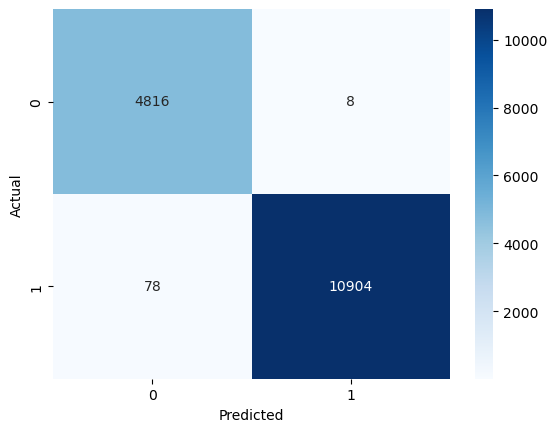

In [11]:
# Train the model 
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model performance
print(f"--- Model Evaluation for {latest_year} season ---")
print(f"Accuracy Score : {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

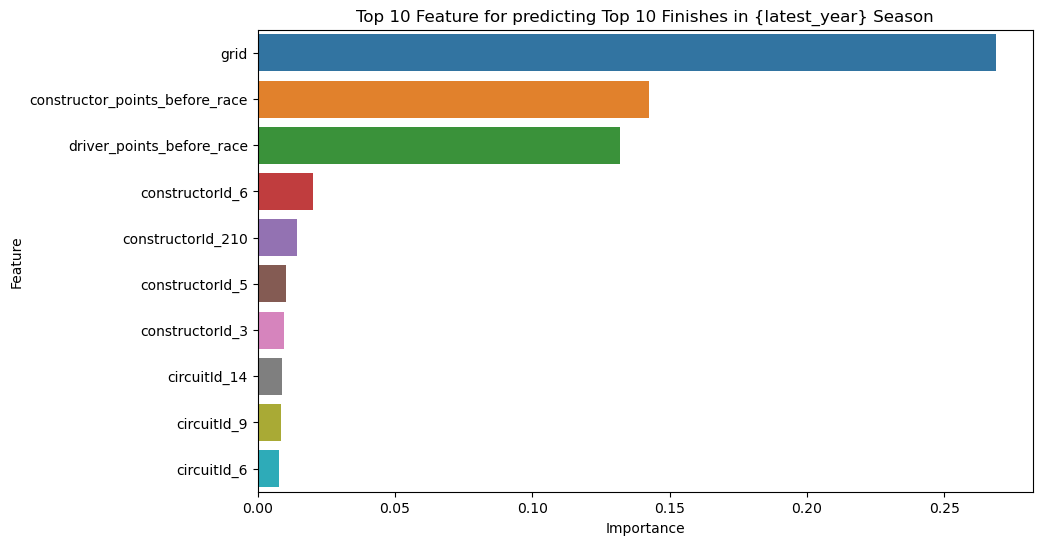

In [12]:
# Get feature importances from the trained model
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(10))
plt.title('Top 10 Feature for predicting Top 10 Finishes in {latest_year} Season')
plt.show()